## Traditional Image Feature Extraction
   #### Computer Vision Winter Semester 2021/2022 by Clemens Spielvogel

Due to SIFT feature extraction being patented, it is not available in the OpenCV main library anymore. To be able to import the SIFT feature extraction functionalities, use pip to install opencv-contrib-python version 3.4.2.16. All needed data is available in the "Data" folder within the jupyter-notebook directory.

Installation (Ubuntu)
* $ pip install opencv-contrib-python==3.4.2.16

* $ pip install sklearn

In [4]:
import os# Function for plotting opencv images in jupyter notebook
from PIL import Image
from IPython.display import display

def display_array(array):
    if len(array.shape) > 2: # Check whether image is colored
        array = cv2.cvtColor(array.astype("uint8"), cv2.COLOR_BGR2RGB) # Swap BGR to RGB
    pil_img = Image.fromarray(array)
    display(pil_img)
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter

In [5]:
# Function for plotting opencv images in jupyter notebook
from PIL import Image
from IPython.display import display

def display_array(array):
    if len(array.shape) > 2: # Check whether image is colored
        array = cv2.cvtColor(array.astype("uint8"), cv2.COLOR_BGR2RGB) # Swap BGR to RGB
    pil_img = Image.fromarray(array)
    display(pil_img)

In [6]:
def display_keypoints(img1, img2, descriptors1, descriptors2, keypoints1, keypoints2, ratio_best_matches=1):
    """Display matched key points of two images"""
    
    # Display number of keypoints detected
    print("Key points detected in image 1: ", len(keypoints1))
    print("Key points detected in image 2: ", len(keypoints2))
    
    # Initialize brute force matcher
    matcher = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

    # Match descriptors of the two images 
    matches = matcher.match(descriptors1, descriptors2)

    # Order matches by distance
    matches = sorted(matches, key=lambda x : x.distance)
    
    # Remove worst matches
    num_best_matches = int(round(len(matches) * ratio_best_matches, 0))
    print(num_best_matches)
    matches = matches[:num_best_matches]

    # Create drawing of matched key points
    result = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches, img2, flags = 2)

    # Display the best matching points
    plt.rcParams["figure.figsize"] = [20.0, 10.0]
    plt.imshow(result)
    plt.show()

    # Display number of matched key points
    print("Number of matched key points: ", len(matches))

### Extracting and displaying SIFT features

In [7]:
# Loading images
path1 = "Data/book1.jpg"
path2 = "Data/book2.jpg"

img1 = cv2.imread(path1, 0)
img2 = cv2.imread(path2, 0)

if img1 is None:
    raise Exception("Error: Cannot load image from path '{}'".format(path1))
if img2 is None:
    raise Exception("Error: Cannot load image from path '{}'".format(path2))
    
print(img1.shape)
print(img2.shape)

(1000, 761)
(3008, 4016)


In [8]:
# Reudcing image sizes - this is just for visualization purposes
img1 = cv2.resize(img1, (round(img1.shape[0] / 2), round(img1.shape[1] / 2)))
img2 = cv2.resize(img2, (round(img2.shape[0] / 4), round(img2.shape[1] / 4)))

In [19]:
# Initiate SIFT extractor
sift = cv2.xfeatures2d.SIFT_create()

# Detect keypoints and descriptors via SIFT
keypoints1, descriptors1 = sift.detectAndCompute(img1, None) # 2nd parameter in case of precomputed keypoints
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

Key points detected in image 1:  319
Key points detected in image 2:  145
5


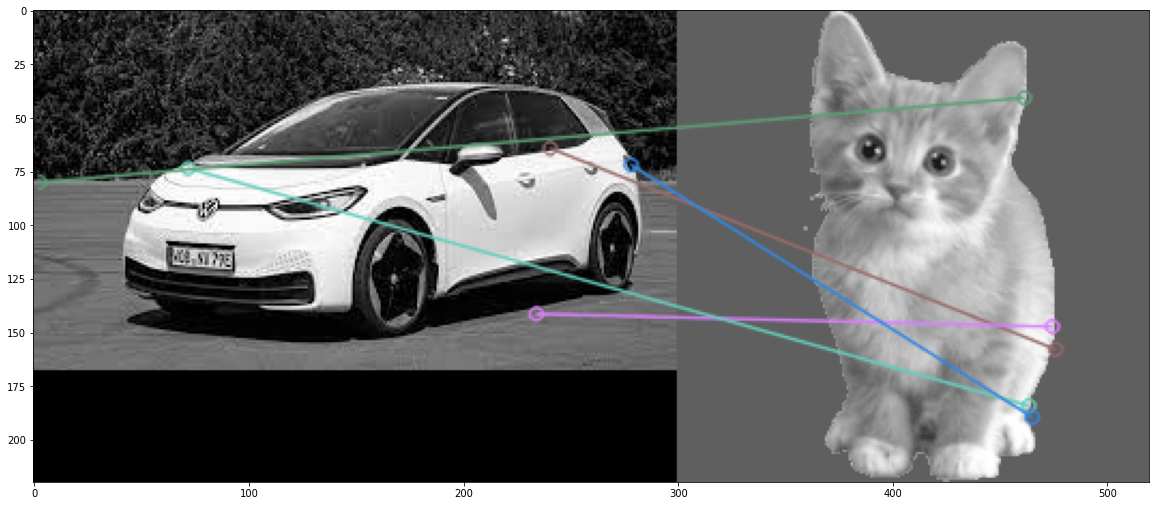

Number of matched key points:  5


In [20]:
# Display matching features
display_keypoints(img1, img2, descriptors1, descriptors2, keypoints1, keypoints2, 0.05)

In [11]:
# Loading images
path1 = "Data/car2.jpg"
path2 = "Data/kitten2.jpg"
img1 = cv2.imread(path1, 0)
img2 = cv2.imread(path2, 0)

if img1 is None:
    raise Exception("Error: Cannot load image from path '{}'".format(path1))
if img2 is None:
    raise Exception("Error: Cannot load image from path '{}'".format(path2))
    
print(img1.shape)
print(img2.shape)

(168, 300)
(220, 220)


In [12]:
# Initiate SIFT extractor
sift = cv2.xfeatures2d.SIFT_create()

# Detect keypoints and descriptors via SIFT
keypoints1, descriptors1 = sift.detectAndCompute(img1, None) # 2nd parameter in case of precomputed keypoints
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

Key points detected in image 1:  319
Key points detected in image 2:  145
5


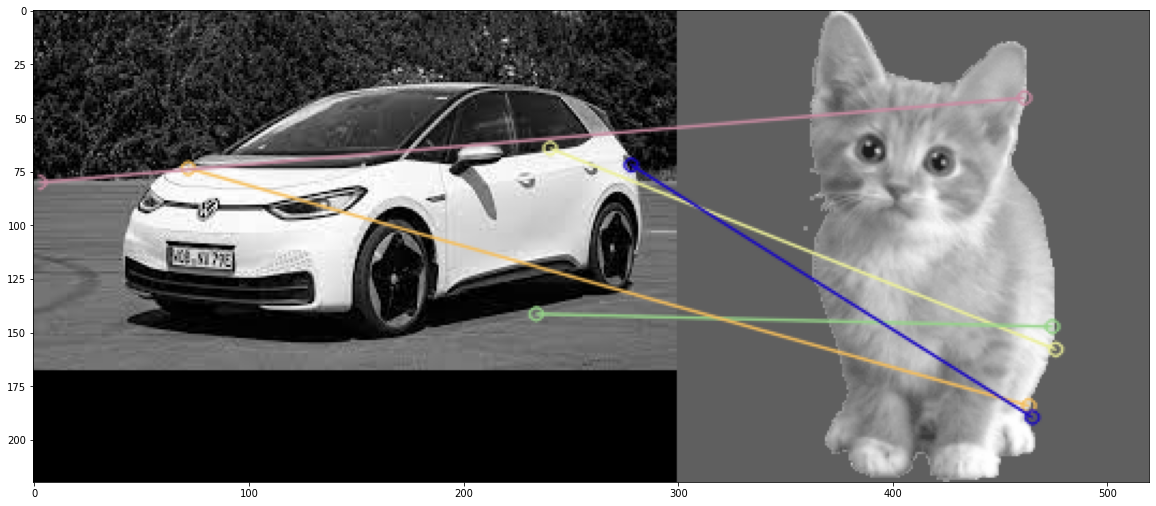

Number of matched key points:  5


In [13]:
# Display matching features
display_keypoints(img1, img2, descriptors1, descriptors2, keypoints1, keypoints2, 0.05)

### Bag of visual words
Bag of visual words (BOVW) is a method using clustering and classification algorithms for identifying similar images based on image feature abundancies. In this example, BOVW is used for classification of kittens and puppys. 

In [14]:
# Initiate SIFT extractor
sift = cv2.xfeatures2d.SIFT_create()

In [15]:
# Create a histogram with descriptors and associated clusters
def build_histogram(descriptors, cluster_algorithm):
    histogram = np.zeros(len(cluster_algorithm.cluster_centers_))
    cluster_result = cluster_algorithm.predict(descriptors)
    for i in cluster_result:
        histogram[i] += 1

    return histogram

In [16]:
# Load data
images = []
paths = []
for file in os.listdir("Data"):
    if file.startswith("kitten") or file.startswith("puppy"):
        images.append(cv2.imread("Data/" + file, 0))
        paths.append(file)

# Create labels
labels = []
for path in paths:
    if path.startswith("kitten"):
        labels.append("kitten")
    else:
        labels.append("puppy")

# Extract SIFT features for each training image
training_descriptors = []
for image in images:
    keypoints, descriptors = sift.detectAndCompute(image, None)
    training_descriptors.append(descriptors)

# Initialize clustering algorithm
kmeans = KMeans(n_clusters=10)

# Stack descriptors into array
stacked_array = np.array(training_descriptors[0])
for descriptor in training_descriptors[1:]:
    stacked_array = np.vstack((stacked_array, descriptor))

kmeans.fit(stacked_array)

# Create histograms for all images
image_histograms = []
for image in images[:-1]: # Leave first sample out for testing
    keypoint, descriptor = sift.detectAndCompute(image, None)
    if descriptor is not None:
        histogram = build_histogram(descriptor, kmeans)
        image_histograms.append(histogram)

In [17]:
# Test image
test_img = images[-1]

keypoint, descriptor = sift.detectAndCompute(test_img, None)
histogram = build_histogram(descriptor, kmeans)
model = KNeighborsClassifier(n_neighbors=5)
model.fit(image_histograms, labels[:-1])

pred = model.predict([histogram])

print("Predicted:", pred[0]) # Predicted result indices in the order of loaded samples
print("Actual:", labels[-1])

Predicted: puppy
Actual: puppy
